Pipeline for Product Review Sentiment Classification and Ranking

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')


In [17]:
from utils.load_data import load_dataset_as_dataframe
from utils.data_cleaner import data_cleaner


# Load data

In [5]:
# 1. Load the Data
df1, df2, df3 = load_dataset_as_dataframe()

# 2. Clean and Merge the Data
dataframes_list = [df1, df2, df3]
source_names_list = ['1429_1', 'Datafiniti_Products', 'Datafinit_Products_May19']

# Clean the data and remove the duplicates
df = data_cleaner(dataframes_list, source_names_list)

Processing DataFrame from '1429_1'...
Finished processing '1429_1'. Found 34660 rows.
Processing DataFrame from 'Datafiniti_Products'...
Finished processing 'Datafiniti_Products'. Found 5000 rows.
Processing DataFrame from 'Datafinit_Products_May19'...
Finished processing 'Datafinit_Products_May19'. Found 28332 rows.

Merging all datasets...
Total rows after merge: 67992
Dropped 2153 duplicate reviews.
Dropped 6810 rows due to missing (MUST HAVE) data.
Final merged dataset has 59029 rows.


In [6]:
# ============================================================================
# PART 1: DATA PREPARATION
# ============================================================================

def prepare_data(df):
    """
    Prepare data for sentiment classification
    
    Args:
        df: DataFrame with columns ['product_name', 'categories', 'review_rating', 
                                     'review_text', 'review_title']
    
    Returns:
        df: DataFrame with added 'sentiment' and 'combined_text' columns
    """
    print("=" * 80)
    print("PART 1: DATA PREPARATION")
    print("=" * 80)
    
    # Create sentiment labels from ratings
    def rating_to_sentiment(rating):
        if rating <= 2:
            return 'negative'
        elif rating == 3:
            return 'neutral'
        else:  # 4-5
            return 'positive'
    
    df['sentiment'] = df['review_rating'].apply(rating_to_sentiment)
    
    # Combine title and text for better context
    df['combined_text'] = (
        df['review_title'].fillna('') + ' ' + df['review_text'].fillna('')
    ).str.strip()
    
    # Remove empty reviews
    df = df[df['combined_text'].str.len() > 0].copy()
    
    print(f"\nDataset shape: {df.shape}")
    print(f"\nSentiment distribution:")
    print(df['sentiment'].value_counts())
    print(f"\nSentiment percentages:")
    print(df['sentiment'].value_counts(normalize=True) * 100)
    
    return df


def create_stratified_split(df, test_size=0.2, random_state=42):
    """
    Create stratified train-test split
    """
    print("\n" + "=" * 80)
    print("CREATING STRATIFIED TRAIN-TEST SPLIT")
    print("=" * 80)
    
    X = df['combined_text']
    y = df['sentiment']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )
    
    print(f"\nTrain set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    print(f"\nTrain set distribution:")
    print(y_train.value_counts())
    print(f"\nTest set distribution:")
    print(y_test.value_counts())
    
    return X_train, X_test, y_train, y_test



In [10]:

# ============================================================================
# PART 2: BASELINE MODEL - LOGISTIC REGRESSION WITH TF-IDF
# ============================================================================

def train_baseline_model(X_train, y_train, X_test, y_test):
    """
    Train Logistic Regression with TF-IDF features
    Handles class imbalance with class_weight='balanced'
    """
    print("\n" + "=" * 80)
    print("PART 2: BASELINE MODEL - LOGISTIC REGRESSION")
    print("=" * 80)
    
    # Vectorize text
    print("\nVectorizing text with TF-IDF...")
    vectorizer = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        strip_accents='unicode',
        lowercase=True
    )
    
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")
    
    # Train Logistic Regression with balanced class weights
    print("\nTraining Logistic Regression (with class balancing)...")
    lr_model = LogisticRegression(
        class_weight='balanced',  # Handles class imbalance
        max_iter=1000,
        random_state=42,
        solver='lbfgs',
        multi_class='multinomial'
    )
    
    lr_model.fit(X_train_tfidf, y_train)
    
    # Predictions
    y_pred = lr_model.predict(X_test_tfidf)
    y_pred_proba = lr_model.predict_proba(X_test_tfidf)
    
    # Evaluation
    print("\n" + "-" * 80)
    print("BASELINE MODEL EVALUATION")
    print("-" * 80)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    
    # F1 scores
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    print(f"\nF1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['negative', 'neutral', 'positive'],
                yticklabels=['negative', 'neutral', 'positive'])
    plt.title('Baseline Model - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return lr_model, vectorizer, y_pred, y_pred_proba


In [11]:


# ============================================================================
# PART 3: ADVANCED MODEL - DISTILBERT (TRANSFORMER)
# ============================================================================

def train_distilbert_model(X_train, y_train, X_test, y_test):
    """
    Fine-tune DistilBERT for sentiment classification
    Note: This requires transformers, torch, and GPU for reasonable training time
    """
    print("\n" + "=" * 80)
    print("PART 3: DISTILBERT MODEL (TRANSFORMER)")
    print("=" * 80)
    
    try:
        from transformers import (
            AutoTokenizer, 
            AutoModelForSequenceClassification,
            Trainer,
            TrainingArguments
        )
        import torch
        from torch.utils.data import Dataset
        
        # Check if transformers is available
        print("\n✓ Transformers library available")
        
        # Define custom dataset
        class SentimentDataset(Dataset):
            def __init__(self, texts, labels, tokenizer, max_length=128):
                self.texts = texts.tolist()
                self.labels = labels.tolist()
                self.tokenizer = tokenizer
                self.max_length = max_length
                
                # Convert labels to integers
                self.label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
                self.labels = [self.label_map[label] for label in self.labels]
            
            def __len__(self):
                return len(self.texts)
            
            def __getitem__(self, idx):
                text = str(self.texts[idx])
                label = self.labels[idx]
                
                encoding = self.tokenizer(
                    text,
                    truncation=True,
                    padding='max_length',
                    max_length=self.max_length,
                    return_tensors='pt'
                )
                
                return {
                    'input_ids': encoding['input_ids'].flatten(),
                    'attention_mask': encoding['attention_mask'].flatten(),
                    'labels': torch.tensor(label, dtype=torch.long)
                }
        
        # Load pre-trained model and tokenizer
        print("\nLoading DistilBERT model and tokenizer...")
        model_name = "distilbert-base-uncased"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=3
        )
        
        # Prepare datasets
        print("Preparing datasets...")
        train_dataset = SentimentDataset(X_train, y_train, tokenizer)
        test_dataset = SentimentDataset(X_test, y_test, tokenizer)
        
        # Calculate class weights
        classes = np.unique(y_train)
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=classes,
            y=y_train
        )
        
        print(f"\nClass weights: {dict(zip(classes, class_weights))}")
        
        # Training arguments
        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=3,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            learning_rate=2e-5,
            weight_decay=0.01,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            logging_dir='./logs',
            logging_steps=100,
            report_to="none"
        )
        
        # Custom Trainer with class weights
        class WeightedTrainer(Trainer):
            def compute_loss(self, model, inputs, return_outputs=False):
                labels = inputs.pop("labels")
                outputs = model(**inputs)
                logits = outputs.logits
                
                # Apply class weights
                weight_tensor = torch.tensor(
                    class_weights, 
                    dtype=torch.float32
                ).to(logits.device)
                
                loss_fct = torch.nn.CrossEntropyLoss(weight=weight_tensor)
                loss = loss_fct(logits, labels)
                
                return (loss, outputs) if return_outputs else loss
        
        # Train model
        print("\nTraining DistilBERT (this may take a while)...")
        trainer = WeightedTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset
        )
        
        trainer.train()
        
        # Evaluate
        print("\n" + "-" * 80)
        print("DISTILBERT MODEL EVALUATION")
        print("-" * 80)
        
        predictions = trainer.predict(test_dataset)
        y_pred = np.argmax(predictions.predictions, axis=1)
        
        # Map back to labels
        label_map_reverse = {0: 'negative', 1: 'neutral', 2: 'positive'}
        y_pred_labels = [label_map_reverse[pred] for pred in y_pred]
        
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_labels, digits=4))
        
        f1_macro = f1_score(y_test, y_pred_labels, average='macro')
        f1_weighted = f1_score(y_test, y_pred_labels, average='weighted')
        print(f"\nF1 Score (Macro): {f1_macro:.4f}")
        print(f"F1 Score (Weighted): {f1_weighted:.4f}")
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_labels, 
                            labels=['negative', 'neutral', 'positive'])
        print("\nConfusion Matrix:")
        print(cm)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                    xticklabels=['negative', 'neutral', 'positive'],
                    yticklabels=['negative', 'neutral', 'positive'])
        plt.title('DistilBERT Model - Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        return model, tokenizer, y_pred_labels, predictions.predictions
        
    except ImportError:
        print("\n⚠ Transformers library not available.")
        print("Install with: pip install transformers torch")
        print("Skipping DistilBERT model...")
        return None, None, None, None


In [12]:


# ============================================================================
# PART 4: PREDICT ON FULL DATASET
# ============================================================================

def predict_full_dataset(df, model, vectorizer, model_type='baseline'):
    """
    Predict sentiments for all reviews in the dataset
    
    Args:
        df: Full DataFrame
        model: Trained model (LogisticRegression or DistilBERT)
        vectorizer: TfidfVectorizer (for baseline) or tokenizer (for DistilBERT)
        model_type: 'baseline' or 'distilbert'
    
    Returns:
        df with added 'predicted_sentiment' and 'confidence_score' columns
    """
    print("\n" + "=" * 80)
    print("PART 4: PREDICTING ON FULL DATASET")
    print("=" * 80)
    
    if model_type == 'baseline':
        print("\nUsing Baseline Model for predictions...")
        X_tfidf = vectorizer.transform(df['combined_text'])
        df['predicted_sentiment'] = model.predict(X_tfidf)
        probas = model.predict_proba(X_tfidf)
        
        # Confidence score = max probability
        df['confidence_score'] = probas.max(axis=1)
        
        # Get positive class probability (for ranking)
        positive_idx = list(model.classes_).index('positive')
        df['positive_proba'] = probas[:, positive_idx]
        
    else:
        print("\nDistilBERT prediction not implemented in this simplified version")
        print("Using baseline model instead...")
        return predict_full_dataset(df, model, vectorizer, 'baseline')
    
    print(f"\nPredictions complete!")
    print(f"Predicted sentiment distribution:")
    print(df['predicted_sentiment'].value_counts())
    
    return df


In [13]:


# ============================================================================
# PART 5: RANKING SYSTEM
# ============================================================================

def calculate_product_scores(df):
    """
    Calculate ranking scores for each product
    
    Combines multiple signals:
    1. Percentage of positive reviews
    2. Average rating
    3. Review count (with Bayesian averaging)
    4. Average confidence score
    """
    print("\n" + "=" * 80)
    print("PART 5: PRODUCT RANKING SYSTEM")
    print("=" * 80)
    
    # Group by product and category
    product_stats = df.groupby(['categories', 'product_name']).agg({
        'predicted_sentiment': lambda x: (x == 'positive').sum() / len(x),
        'positive_proba': 'mean',
        'review_rating': 'mean',
        'confidence_score': 'mean',
        'review_text': 'count'
    }).reset_index()
    
    product_stats.columns = [
        'category', 'product', 'positive_ratio', 'avg_positive_proba',
        'avg_rating', 'avg_confidence', 'review_count'
    ]
    
    # Bayesian average for rating (handles products with few reviews)
    C = 10  # Confidence parameter (minimum reviews to trust)
    m = df['review_rating'].mean()  # Global average rating
    
    product_stats['bayesian_rating'] = (
        (C * m + product_stats['review_count'] * product_stats['avg_rating']) /
        (C + product_stats['review_count'])
    )
    
    # Combined ranking score (weighted formula)
    # You can adjust these weights based on importance
    product_stats['ranking_score'] = (
        0.30 * product_stats['positive_ratio'] +
        0.25 * (product_stats['bayesian_rating'] / 5.0) +
        0.25 * product_stats['avg_positive_proba'] +
        0.10 * product_stats['avg_confidence'] +
        0.10 * np.log1p(product_stats['review_count']) / np.log1p(df.shape[0])
    )
    
    print(f"\nCalculated scores for {len(product_stats)} products")
    
    return product_stats


def get_top_products(product_stats, top_n=3):
    """
    Get top N products for each category
    """
    print("\n" + "=" * 80)
    print(f"TOP {top_n} PRODUCTS PER CATEGORY")
    print("=" * 80)
    
    top_products = (
        product_stats
        .sort_values('ranking_score', ascending=False)
        .groupby('category')
        .head(top_n)
        .reset_index(drop=True)
    )
    
    # Display results
    for category in top_products['category'].unique():
        print(f"\n{'=' * 80}")
        print(f"Category: {category}")
        print('=' * 80)
        
        cat_products = top_products[top_products['category'] == category]
        
        for idx, row in cat_products.iterrows():
            print(f"\n{idx+1}. {row['product']}")
            print(f"   Ranking Score: {row['ranking_score']:.4f}")
            print(f"   Positive Reviews: {row['positive_ratio']*100:.1f}%")
            print(f"   Average Rating: {row['avg_rating']:.2f}/5.0")
            print(f"   Bayesian Rating: {row['bayesian_rating']:.2f}/5.0")
            print(f"   Review Count: {int(row['review_count'])}")
            print(f"   Confidence: {row['avg_confidence']:.3f}")
    
    return top_products


def visualize_rankings(top_products):
    """
    Visualize top products per category
    """
    print("\n" + "=" * 80)
    print("VISUALIZATION")
    print("=" * 80)
    
    # Get top 5 categories by number of products
    top_categories = (
        top_products['category']
        .value_counts()
        .head(5)
        .index
    )
    
    fig, axes = plt.subplots(len(top_categories), 1, 
                             figsize=(12, 4*len(top_categories)))
    
    if len(top_categories) == 1:
        axes = [axes]
    
    for idx, category in enumerate(top_categories):
        cat_data = top_products[top_products['category'] == category]
        
        axes[idx].barh(cat_data['product'], cat_data['ranking_score'], 
                      color='steelblue')
        axes[idx].set_xlabel('Ranking Score')
        axes[idx].set_title(f'Top Products in {category}')
        axes[idx].invert_yaxis()
        
        # Add value labels
        for i, v in enumerate(cat_data['ranking_score']):
            axes[idx].text(v, i, f' {v:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()



In [14]:

# ============================================================================
# MAIN EXECUTION PIPELINE
# ============================================================================

def run_complete_pipeline(df):
    """
    Execute the complete pipeline from data prep to ranking
    
    Args:
        df: DataFrame with columns ['product_name', 'categories', 'review_rating',
                                     'review_text', 'review_title']
    """
    print("\n" + "=" * 80)
    print("STARTING COMPLETE PIPELINE")
    print("=" * 80)
    
    # Step 1: Prepare data
    df = prepare_data(df)
    
    # Step 2: Create train-test split
    X_train, X_test, y_train, y_test = create_stratified_split(df)
    
    # Step 3: Train baseline model
    lr_model, vectorizer, y_pred_lr, y_pred_proba_lr = train_baseline_model(
        X_train, y_train, X_test, y_test
    )
    
    # Step 4: (Optional) Train DistilBERT
    # Uncomment if you have transformers installed and GPU available
    # distilbert_model, tokenizer, y_pred_bert, y_pred_proba_bert = train_distilbert_model(
    #     X_train, y_train, X_test, y_test
    # )
    
    # Step 5: Predict on full dataset
    df = predict_full_dataset(df, lr_model, vectorizer, model_type='baseline')
    
    # Step 6: Calculate product scores
    product_stats = calculate_product_scores(df)
    
    # Step 7: Get top products per category
    top_products = get_top_products(product_stats, top_n=3)
    
    # Step 8: Visualize
    visualize_rankings(top_products)
    
    print("\n" + "=" * 80)
    print("PIPELINE COMPLETE!")
    print("=" * 80)
    
    return df, product_stats, top_products


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

if __name__ == "__main__":
    # Load your data
    # df = pd.read_csv('your_reviews.csv')
    
    # Or create sample data for testing
    print("To use this pipeline with your data:")
    print("\n1. Load your DataFrame:")
    print("   df = pd.read_csv('your_reviews.csv')")
    print("\n2. Ensure it has these columns:")
    print("   ['product_name', 'categories', 'review_rating', 'review_text', 'review_title']")
    print("\n3. Run the pipeline:")
    print("   df, product_stats, top_products = run_complete_pipeline(df)")
    print("\n4. Export results:")
    print("   top_products.to_csv('top_products_ranked.csv', index=False)")

To use this pipeline with your data:

1. Load your DataFrame:
   df = pd.read_csv('your_reviews.csv')

2. Ensure it has these columns:
   ['product_name', 'categories', 'review_rating', 'review_text', 'review_title']

3. Run the pipeline:
   df, product_stats, top_products = run_complete_pipeline(df)

4. Export results:
   top_products.to_csv('top_products_ranked.csv', index=False)



STARTING COMPLETE PIPELINE
PART 1: DATA PREPARATION

Dataset shape: (59029, 14)

Sentiment distribution:
sentiment
positive    54078
neutral      2629
negative     2322
Name: count, dtype: int64

Sentiment percentages:
sentiment
positive    91.612597
neutral      4.453743
negative     3.933660
Name: proportion, dtype: float64

CREATING STRATIFIED TRAIN-TEST SPLIT

Train set size: 47223
Test set size: 11806

Train set distribution:
sentiment
positive    43262
neutral      2103
negative     1858
Name: count, dtype: int64

Test set distribution:
sentiment
positive    10816
neutral       526
negative      464
Name: count, dtype: int64

PART 2: BASELINE MODEL - LOGISTIC REGRESSION

Vectorizing text with TF-IDF...
TF-IDF matrix shape: (47223, 5000)

Training Logistic Regression (with class balancing)...

--------------------------------------------------------------------------------
BASELINE MODEL EVALUATION
--------------------------------------------------------------------------------



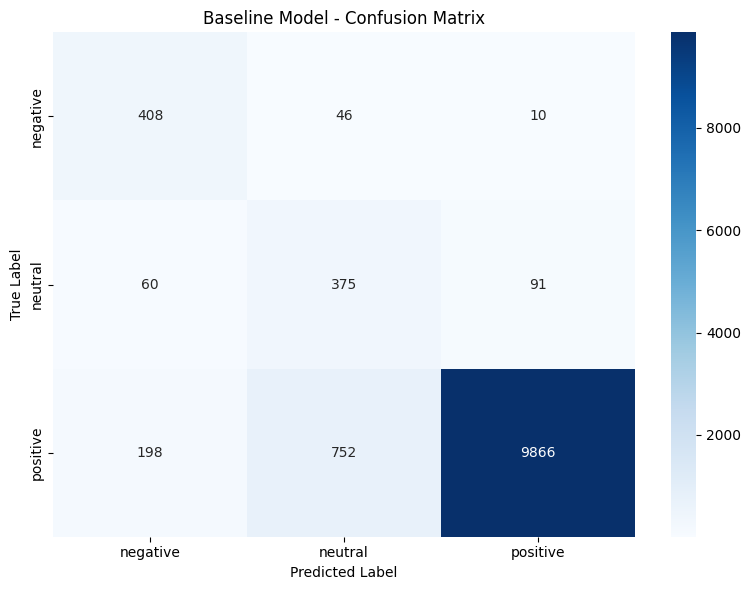


PART 4: PREDICTING ON FULL DATASET

Using Baseline Model for predictions...

Predictions complete!
Predicted sentiment distribution:
predicted_sentiment
positive    49794
neutral      5970
negative     3265
Name: count, dtype: int64

PART 5: PRODUCT RANKING SYSTEM

Calculated scores for 154 products

TOP 3 PRODUCTS PER CATEGORY

Category: Walmart for Business,Office Electronics,Tablets,Office,Electronics,iPad & Tablets,Windows Tablets,All Windows Tablets,Computers & Tablets,E-Readers & Accessories,E-Readers,eBook Readers,Kindle E-readers,Computers/Tablets & Networking,Tablets & eBook Readers,Electronics Features,Books & Magazines,Book Accessories,eReaders,TVs & Electronics,Computers & Laptops,Tablets & eReaders

1. Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,,,
   Ranking Score: 0.8878
   Positive Reviews: 92.5%
   Average Rating: 4.77/5.0
   Bayesian Rating: 4.77/5.0
   Review Count: 2928
   Confidence: 0.875

21. Kindle Voya

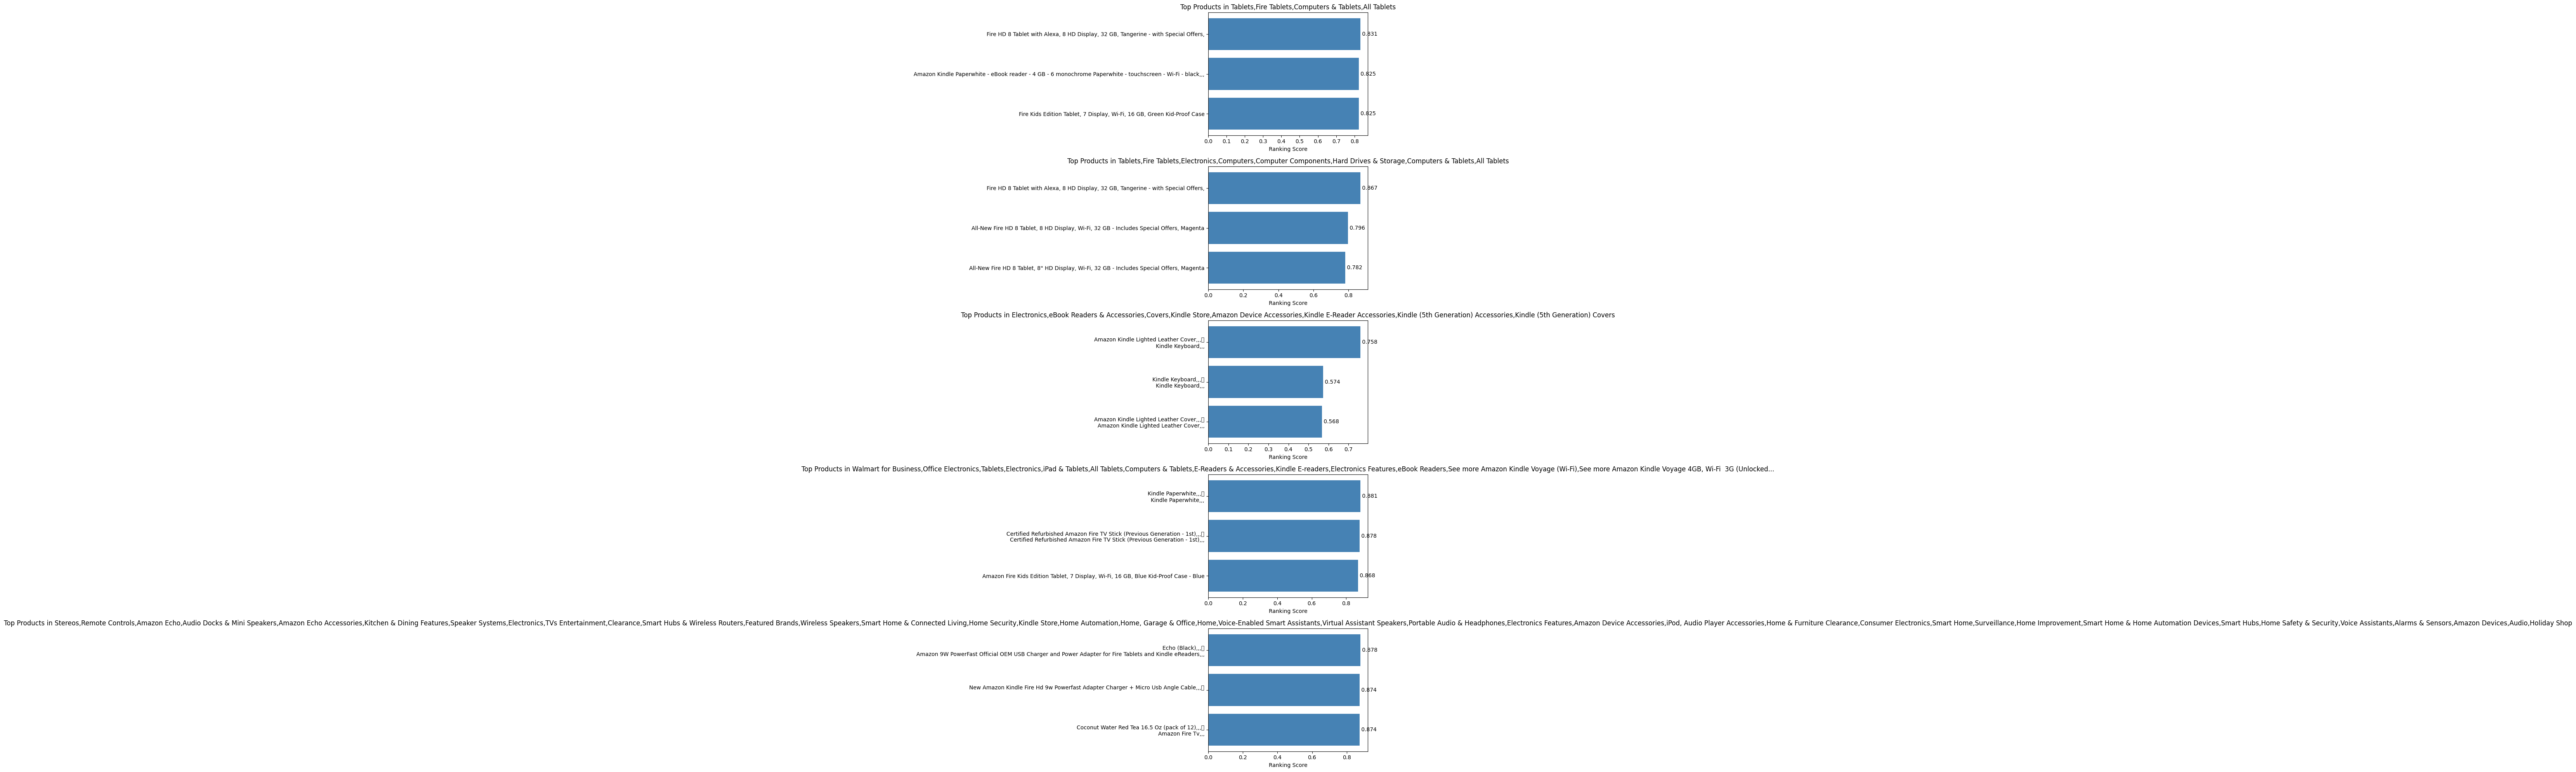


PIPELINE COMPLETE!


In [18]:
df, product_stats, top_products = run_complete_pipeline(df)